In [1]:
from joblib import load
import sys
from Sparse_vector.sparse_vector import SparseVector
from joblib import load
from tqdm import trange
from tqdm.notebook import tqdm
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve

In [2]:
import urllib.request

url = "https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes"
filename = "hg38.chrom.sizes"

urllib.request.urlretrieve(url, filename)
chrom_sizes_file = "hg38.chrom.sizes"

def get_chrom_sizes():
    chrom_sizes = {}
    with open(chrom_sizes_file) as f:
        for line in f:
            name, size = line.strip().split("\t")
            chrom_sizes[name] = int(size)
    return chrom_sizes
  
chr_size = get_chrom_sizes()

In [3]:
chrom_names = [f'chr{i}' for i in list(range(1, 23)) + ['X', 'Y','M']]
features = [i[:-4] for i in os.listdir('omicDC_results_Breast/')]
groups = ['Histone','TFs']
feature_names = [i for i in features if (i.split('_')[0] in groups)]
DNA_features = {feture: load(f'omicDC_results_Breast/{feture}.pkl')
                for feture in tqdm(feature_names)}

  0%|          | 0/405 [00:00<?, ?it/s]

In [4]:
from collections import defaultdict

result_dict = defaultdict(set)

with open("breast.bed", "r") as bed_file:

    for line in bed_file:

        chrom, start, end = line.strip().split("\t")[:3]
        start, end = int(start), int(end)
        result_dict[chrom].update(set(range(start, end+1)))


In [5]:
win_in = []
win_out = []
width = 50000
ws = [-20*width, -10*width, -5*width, 5*width, 10*width, 20*width]

for chrm in tqdm(chrom_names):
    print(chrm)
    first_time = True
    for pos in result_dict[chrm]:  
        win_in.append([chrm, max(pos - width//2, 0), min(pos + width//2, chr_size[chrm])])
        for w in ws:
            if w < 0:
                w = abs(w)
                pos -= w
            else:
                pos += w
            interval = [min(max(pos - width//2, 0), chr_size[chrm]), max(0, min(pos + width//2, chr_size[chrm]))]
            is_in = False
            for i in range(interval[0], interval[1]+1):
                if interval[0] + i in result_dict[chrm]:
                    is_in = True
                    break
            if not is_in and interval[0] != interval[1]:
                win_out.append([chrm, interval[0], interval[1]])

  0%|          | 0/25 [00:00<?, ?it/s]

chr1
chr2
chr3
chr4
chr5
chr6
chr7
chr8
chr9
chr10
chr11
chr12
chr13
chr14
chr15
chr16
chr17
chr18
chr19
chr20
chr21
chr22
chrX
chrY
chrM


In [6]:
win_in[:10]

[['chr1', 198024792, 198074792],
 ['chr1', 58039907, 58089907],
 ['chr1', 226988450, 227038450],
 ['chr1', 226988451, 227038451],
 ['chr1', 166567532, 166617532],
 ['chr1', 8232559, 8282559],
 ['chr1', 53321328, 53371328],
 ['chr1', 53321329, 53371329],
 ['chr1', 53321330, 53371330],
 ['chr1', 8232560, 8282560]]

In [7]:
win_out[:10]

[['chr1', 197024792, 197074792],
 ['chr1', 196524792, 196574792],
 ['chr1', 196274792, 196324792],
 ['chr1', 196524792, 196574792],
 ['chr1', 197024792, 197074792],
 ['chr1', 198024792, 198074792],
 ['chr1', 225988450, 226038450],
 ['chr1', 225488450, 225538450],
 ['chr1', 225238450, 225288450],
 ['chr1', 225488450, 225538450]]

In [8]:
print(len(win_in), len(win_out))

645495 2416368


In [9]:
sample_size = len(win_in) // 10

random_indices = np.random.choice(range(len(win_in)), size=sample_size, replace=False)
ints_in1 = np.array(win_in)[random_indices]
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(ints_in1), replace=False)]

In [10]:
ints_in1 = np.array(win_in)
ints_out1 = np.array(win_out)[np.random.choice(range(len(win_out)), size=len(win_in), replace=False)]

In [11]:
print(len(ints_in1), len(ints_out1))

645495 645495


In [12]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

equalized1 = [[inter[0], int(inter[1]), int(inter[2]), 1] for inter in ints_in1]
equalized0 = [[inter[0], int(inter[1]), int(inter[2]), 0] for inter in ints_out1]
equalized = np.vstack((equalized1, equalized0))

np.random.shuffle(equalized)
equalized[0:10]

array([['chr6', '2140342', '2190342', '1'],
       ['chr17', '33231805', '33281805', '1'],
       ['chr20', '57077206', '57127206', '0'],
       ['chr11', '73472113', '73522113', '1'],
       ['chr1', '28381025', '28431025', '1'],
       ['chr6', '102528884', '102578884', '0'],
       ['chr19', '54185505', '54235505', '0'],
       ['chr1', '179764650', '179814650', '0'],
       ['chr1', '65292942', '65342942', '1'],
       ['chr2', '182037697', '182087697', '1']], dtype='<U21')

In [18]:
import numpy as np
import torch
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

X = []
y = []

pbar = tqdm(total=len(equalized))

for idx in range(len(equalized)):
    pbar.update(1)
    inter = equalized[idx]
    chrom = inter[0]
    begin = int(inter[1])
    end = int(inter[2])
    target = int(inter[3])
    feature_matr = []
    for feature in feature_names:
        source = DNA_features[feature]
        feature_matr.append(source[chrom][begin:end].mean())

    if len(feature_matr) > 0:
        new_row = np.hstack(np.array(feature_matr).T).astype(np.float32)
        X.append(new_row)
        y.append(target)
    else:
        continue 

pbar.close()

 50%|████████████████████████████████████████████████████████████████████▍                                                                    | 64488/129098 [51:52<48:28, 22.21it/s]

In [19]:
X = np.array(X)

scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

X = torch.tensor(X_normalized, dtype=torch.float)
y = torch.tensor(y, dtype=torch.int64)

In [20]:
X = np.array(X)
X

In [41]:
X

array([[ 4.906155  , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [ 0.8756607 , -0.12221713, -0.04537331, ...,  0.04012718,
        -0.17250815, -0.04198911],
       [ 0.9096736 , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       ...,
       [-0.43855238, -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [ 0.6270733 ,  0.2527018 , -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [-0.620844  , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911]], dtype=float32)

In [40]:
y

tensor([0, 1, 1,  ..., 1, 0, 1])

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.array(y_train)
y_test = np.array(y_test)

X_train = tf.keras.utils.normalize(X_train, axis=1)
X_test = tf.keras.utils.normalize(X_test, axis=1)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

model = Sequential()
model.add(SimpleRNN(units=64, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC score: {:.4f}".format(roc_auc))


Epoch 1/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6938 - val_accuracy: 0.4975
Epoch 2/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6932 - accuracy: 0.5012 - val_loss: 0.6931 - val_accuracy: 0.5036
Epoch 3/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6934 - val_accuracy: 0.5023
Epoch 4/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6932 - accuracy: 0.5011 - val_loss: 0.6931 - val_accuracy: 0.5029
Epoch 5/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 6/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4973
Epoch 7/10
3228/3228 [==============================] - 68s 21ms/step - loss: 0.6932 - accuracy: 0.5022 - val_loss: 0.6932 -

In [43]:
X

array([[ 4.906155  , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [ 0.8756607 , -0.12221713, -0.04537331, ...,  0.04012718,
        -0.17250815, -0.04198911],
       [ 0.9096736 , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       ...,
       [-0.43855238, -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [ 0.6270733 ,  0.2527018 , -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911],
       [-0.620844  , -0.12221713, -0.04537331, ..., -0.21342014,
        -0.17250815, -0.04198911]], dtype=float32)

In [44]:
y

tensor([0, 1, 1,  ..., 1, 0, 1])

In [45]:
from copy import deepcopy
X_copy = deepcopy(X)
y_copy = deepcopy(y)

In [46]:
X = X_copy
y = y_copy

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        if np.array(true_labels).std() == 0:
            roc_auc = 0
        else:
            roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_26437/3757297636.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_26437/3757297636.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6871, Train F1-score: 0.4405, Train ROC-AUC: 0.4444, Train PR-AUC: 0.6863, Test Loss: 0.6835, Test F1-score: 0.5497, Test ROC-AUC: 0.5755, Test PR-AUC: 0.5727
Epoch [2/20], Train Loss: 0.6753, Train F1-score: 0.6533, Train ROC-AUC: 0.7500, Train PR-AUC: 0.6850, Test Loss: 0.6782, Test F1-score: 0.5636, Test ROC-AUC: 0.5936, Test PR-AUC: 0.5966
Epoch [3/20], Train Loss: 0.6589, Train F1-score: 0.7823, Train ROC-AUC: 0.9167, Train PR-AUC: 0.8873, Test Loss: 0.6752, Test F1-score: 0.5627, Test ROC-AUC: 0.6023, Test PR-AUC: 0.6057
Epoch [4/20], Train Loss: 0.6394, Train F1-score: 0.5625, Train ROC-AUC: 0.6327, Train PR-AUC: 0.7016, Test Loss: 0.6865, Test F1-score: 0.5760, Test ROC-AUC: 0.6137, Test PR-AUC: 0.6177
Epoch [5/20], Train Loss: 0.6206, Train F1-score: 0.4974, Train ROC-AUC: 0.6327, Train PR-AUC: 0.6275, Test Loss: 0.6775, Test F1-score: 0.5757, Test ROC-AUC: 0.6159, Test PR-AUC: 0.6200
Epoch [6/20], Train Loss: 0.6027, Train F1-score: 0.4167, Train R

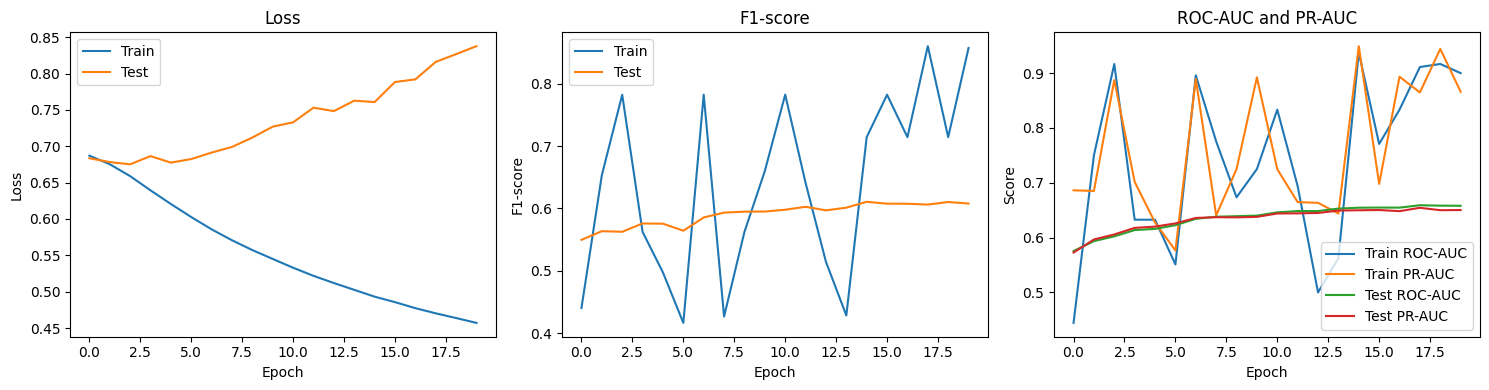

In [49]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [50]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out.squeeze(1)

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 1
num_epochs = 20
batch_size = 64
learning_rate = 0.0001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device) 
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)


model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = torch.sigmoid(outputs).cpu().detach().numpy()
        predicted_probs.extend(probs)
        preds = (probs > 0.5).astype(int)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds)

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = torch.sigmoid(test_outputs).cpu().detach().numpy()
        test_predicted_probs = probs
        test_preds = (probs > 0.5).astype(int)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds, average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)



/tmp/ipykernel_26437/1626131257.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)  # Изменение: тип данных float
/tmp/ipykernel_26437/1626131257.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)  # Изменение: тип данных float


Epoch [1/20], Train Loss: 0.6916, Train F1-score: 0.5185, Train ROC-AUC: 0.5297, Train PR-AUC: 0.5287, Test Loss: 0.6891, Test F1-score: 0.5385, Test ROC-AUC: 0.5548, Test PR-AUC: 0.5456
Epoch [2/20], Train Loss: 0.6888, Train F1-score: 0.5331, Train ROC-AUC: 0.5506, Train PR-AUC: 0.5491, Test Loss: 0.6865, Test F1-score: 0.5365, Test ROC-AUC: 0.5656, Test PR-AUC: 0.5588
Epoch [3/20], Train Loss: 0.6874, Train F1-score: 0.5362, Train ROC-AUC: 0.5553, Train PR-AUC: 0.5559, Test Loss: 0.6853, Test F1-score: 0.5483, Test ROC-AUC: 0.5698, Test PR-AUC: 0.5645
Epoch [4/20], Train Loss: 0.6862, Train F1-score: 0.5394, Train ROC-AUC: 0.5602, Train PR-AUC: 0.5616, Test Loss: 0.6841, Test F1-score: 0.5485, Test ROC-AUC: 0.5748, Test PR-AUC: 0.5707
Epoch [5/20], Train Loss: 0.6853, Train F1-score: 0.5431, Train ROC-AUC: 0.5634, Train PR-AUC: 0.5666, Test Loss: 0.6834, Test F1-score: 0.5388, Test ROC-AUC: 0.5767, Test PR-AUC: 0.5725
Epoch [6/20], Train Loss: 0.6840, Train F1-score: 0.5431, Train R

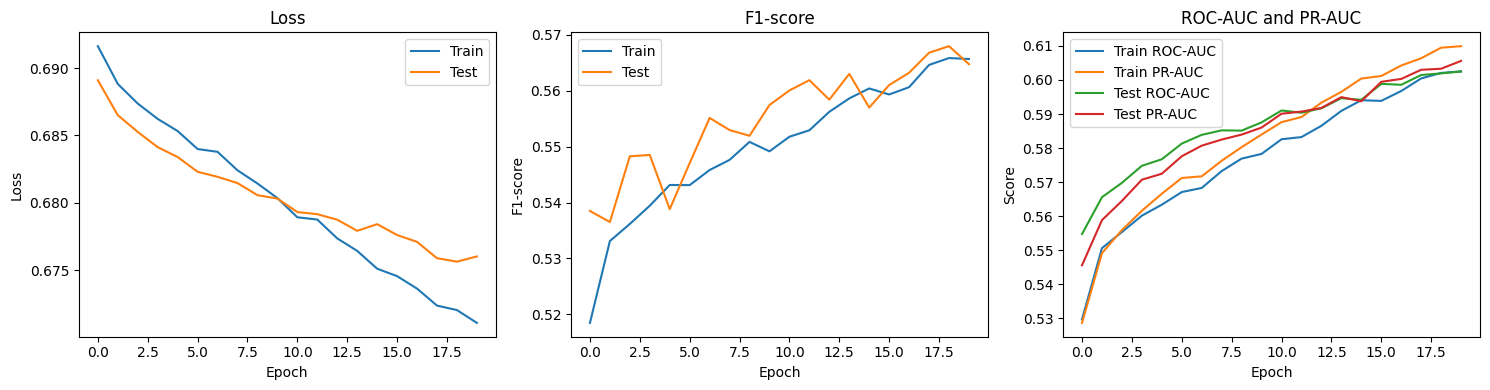

In [51]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [52]:
from sklearn.metrics import accuracy_score
def permutation_importance(model, X_test, y_test, metric, feature_names):
    base_score = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test)) > 0.5).cpu().numpy().astype(int))
    feature_importances = []
    X_test_permuted = X_test.clone()
    for i in range(X_test.shape[-1]):
        np.random.shuffle(X_test_permuted[:, :, i].cpu().numpy())
        score_permuted = metric(y_test.cpu().numpy(), (torch.sigmoid(model(X_test_permuted)) > 0.5).cpu().numpy().astype(int))
        feature_importances.append(base_score - score_permuted)
        X_test_permuted = X_test.clone() 
    
    feature_importance_dict = {name: importance for name, importance in zip(feature_names, feature_importances)}
    sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)
    return sorted_importances

feat_names = feature_names

sorted_feature_importances = permutation_importance(model, X_test, y_test, accuracy_score, feat_names)

for name, imp in sorted_feature_importances:
    print(f'Feature {name} importance: {imp}')


Feature TFs_SFPQ importance: 0.009953524399690106
Feature TFs_JUNB importance: 0.005770720371804705
Feature TFs_TRIM25 importance: 0.005731990704879841
Feature TFs_NR3C1 importance: 0.003214562354763695
Feature Histone_H3K9me3 importance: 0.0029047250193647844
Feature TFs_ERBB2 importance: 0.002633617350890738
Feature TFs_NR2F2 importance: 0.002633617350890738
Feature Histone_H2A.XS139ph importance: 0.0025561580170410103
Feature TFs_ARID2 importance: 0.0025174283501161465
Feature Histone_H3K36me3 importance: 0.002401239349341555
Feature TFs_YAP1 importance: 0.002401239349341555
Feature TFs_SATB1 importance: 0.0023625096824166913
Feature TFs_ZMYND8 importance: 0.0023625096824166913
Feature TFs_8-Hydroxydeoxyguanosine importance: 0.0023237800154918276
Feature TFs_ELF1 importance: 0.0022850503485669638
Feature TFs_MED1 importance: 0.0022850503485669638
Feature TFs_AR importance: 0.0022463206816421
Feature Histone_H3K27me3 importance: 0.002207591014717236
Feature Histone_H3K79me2 importanc

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import torch.nn.functional as F

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        x = self.dropout(x)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out


input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = BiLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        true_labels = []
        predicted_labels = []
        predicted_probs = []

        for i, (inputs, labels) in enumerate(data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        epoch_loss /= len(data_loader)
        f1 = f1_score(true_labels, predicted_labels, average='weighted')
        roc_auc = roc_auc_score(true_labels, predicted_probs)
        pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
        pr_auc = auc(re, pr)

        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            probs = nn.functional.softmax(test_outputs, dim=1)
            test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
            _, test_preds = torch.max(test_outputs, 1)
            test_true_labels = y_test.cpu().numpy()
            test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
            test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
            test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
            test_pr_auc = auc(test_re, test_pr)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

        train_loss_values.append(epoch_loss)
        train_f1_values.append(f1)
        train_roc_auc_values.append(roc_auc)
        train_pr_auc_values.append(pr_auc)
        test_loss_values.append(test_loss.item())
        test_f1_values.append(test_f1)
        test_roc_auc_values.append(test_roc_auc)
        test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_26437/528756788.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_26437/528756788.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6915, Train F1-score: 0.6714, Train ROC-AUC: 0.8750, Train PR-AUC: 0.8243, Test Loss: 0.6870, Test F1-score: 0.5140, Test ROC-AUC: 0.5614, Test PR-AUC: 0.5559
Epoch [2/20], Train Loss: 0.6883, Train F1-score: 0.5536, Train ROC-AUC: 0.5625, Train PR-AUC: 0.5711, Test Loss: 0.6859, Test F1-score: 0.4930, Test ROC-AUC: 0.5678, Test PR-AUC: 0.5629
Epoch [3/20], Train Loss: 0.6858, Train F1-score: 0.7083, Train ROC-AUC: 0.7143, Train PR-AUC: 0.7993, Test Loss: 0.6841, Test F1-score: 0.5420, Test ROC-AUC: 0.5744, Test PR-AUC: 0.5715
Epoch [4/20], Train Loss: 0.6845, Train F1-score: 0.5143, Train ROC-AUC: 0.5833, Train PR-AUC: 0.6971, Test Loss: 0.6826, Test F1-score: 0.5503, Test ROC-AUC: 0.5807, Test PR-AUC: 0.5787
Epoch [5/20], Train Loss: 0.6824, Train F1-score: 0.7143, Train ROC-AUC: 0.6735, Train PR-AUC: 0.6774, Test Loss: 0.6823, Test F1-score: 0.5426, Test ROC-AUC: 0.5822, Test PR-AUC: 0.5818
Epoch [6/20], Train Loss: 0.6810, Train F1-score: 0.5080, Train R

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs[:, 1] > 0.5).long()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

        softmax = nn.Softmax(dim=1)
        probs = softmax(outputs)
        predicted_probs.extend(probs[:, 1].detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_probs = softmax(test_outputs)
        test_preds = (test_probs[:, 1] > 0.5).long()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')
        
        softmax = nn.Softmax(dim=1)
        test_probs = softmax(test_outputs)
        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_probs[:, 1].cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_26437/1862407589.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.long).to(device)
/tmp/ipykernel_26437/1862407589.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.long).to(device)


Epoch [1/20], Train Loss: 0.6870, Train F1-score: 0.5363, Train ROC-AUC: 0.5564, Train PR-AUC: 0.5587, Test Loss: 0.6835, Test F1-score: 0.5524, Test ROC-AUC: 0.5773, Test PR-AUC: 0.5722
Epoch [2/20], Train Loss: 0.6765, Train F1-score: 0.5620, Train ROC-AUC: 0.5954, Train PR-AUC: 0.6002, Test Loss: 0.6801, Test F1-score: 0.5490, Test ROC-AUC: 0.5903, Test PR-AUC: 0.5897
Epoch [3/20], Train Loss: 0.6634, Train F1-score: 0.5845, Train ROC-AUC: 0.6299, Train PR-AUC: 0.6369, Test Loss: 0.6797, Test F1-score: 0.5595, Test ROC-AUC: 0.5974, Test PR-AUC: 0.5938
Epoch [4/20], Train Loss: 0.6484, Train F1-score: 0.6060, Train ROC-AUC: 0.6640, Train PR-AUC: 0.6695, Test Loss: 0.6754, Test F1-score: 0.5714, Test ROC-AUC: 0.6099, Test PR-AUC: 0.6070
Epoch [5/20], Train Loss: 0.6358, Train F1-score: 0.6267, Train ROC-AUC: 0.6901, Train PR-AUC: 0.6916, Test Loss: 0.6744, Test F1-score: 0.5742, Test ROC-AUC: 0.6164, Test PR-AUC: 0.6069
Epoch [6/20], Train Loss: 0.6239, Train F1-score: 0.6433, Train R

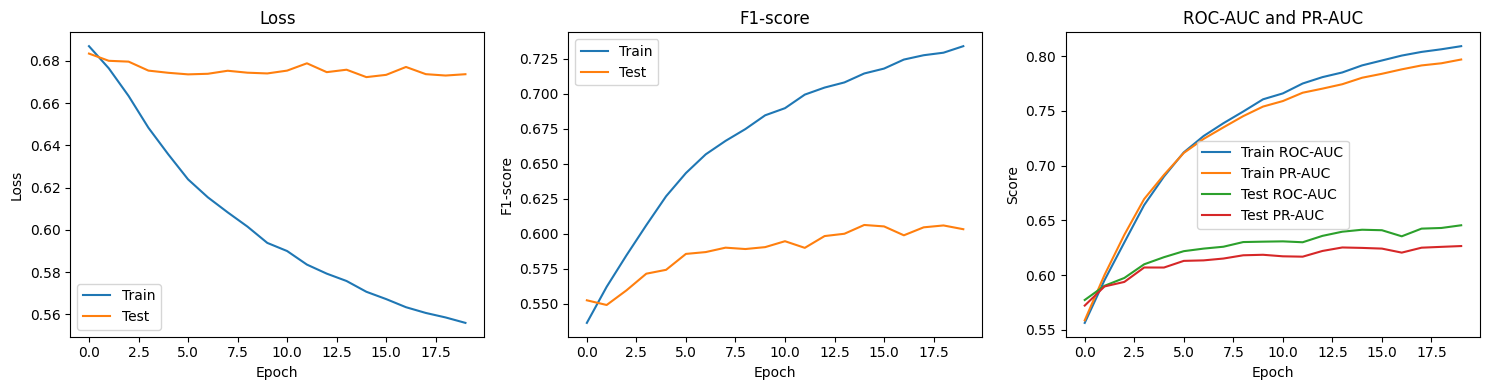

In [55]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout_prob)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        out = self.sigmoid(out)
        return out.squeeze()

input_size = X.shape[1]
hidden_size = 128
num_layers = 2
num_epochs = 30
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

dropout_prob = 0.5
train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, dropout_prob).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = (outputs > 0.5).float()

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
        predicted_probs.extend(outputs.detach().cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr_auc = average_precision_score(true_labels, predicted_probs)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_preds = (test_outputs > 0.5).float()
        test_f1 = f1_score(y_test.cpu().numpy(), test_preds.cpu().numpy(), average='weighted')

        test_roc_auc = roc_auc_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
        test_pr_auc = average_precision_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)


/tmp/ipykernel_26437/792856689.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float).to(device)
/tmp/ipykernel_26437/792856689.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float).to(device)


Epoch [1/30], Train Loss: 0.6889, Train F1-score: 0.5303, Train ROC-AUC: 0.5467, Train PR-AUC: 0.5479, Test Loss: 0.6856, Test F1-score: 0.5329, Test ROC-AUC: 0.5690, Test PR-AUC: 0.5684
Epoch [2/30], Train Loss: 0.6831, Train F1-score: 0.5469, Train ROC-AUC: 0.5720, Train PR-AUC: 0.5759, Test Loss: 0.6816, Test F1-score: 0.5570, Test ROC-AUC: 0.5818, Test PR-AUC: 0.5823
Epoch [3/30], Train Loss: 0.6789, Train F1-score: 0.5533, Train ROC-AUC: 0.5840, Train PR-AUC: 0.5904, Test Loss: 0.6796, Test F1-score: 0.5481, Test ROC-AUC: 0.5874, Test PR-AUC: 0.5898
Epoch [4/30], Train Loss: 0.6736, Train F1-score: 0.5626, Train ROC-AUC: 0.5990, Train PR-AUC: 0.6069, Test Loss: 0.6780, Test F1-score: 0.5626, Test ROC-AUC: 0.5923, Test PR-AUC: 0.5939
Epoch [5/30], Train Loss: 0.6675, Train F1-score: 0.5723, Train ROC-AUC: 0.6122, Train PR-AUC: 0.6231, Test Loss: 0.6755, Test F1-score: 0.5607, Test ROC-AUC: 0.6005, Test PR-AUC: 0.6026
Epoch [6/30], Train Loss: 0.6625, Train F1-score: 0.5786, Train R

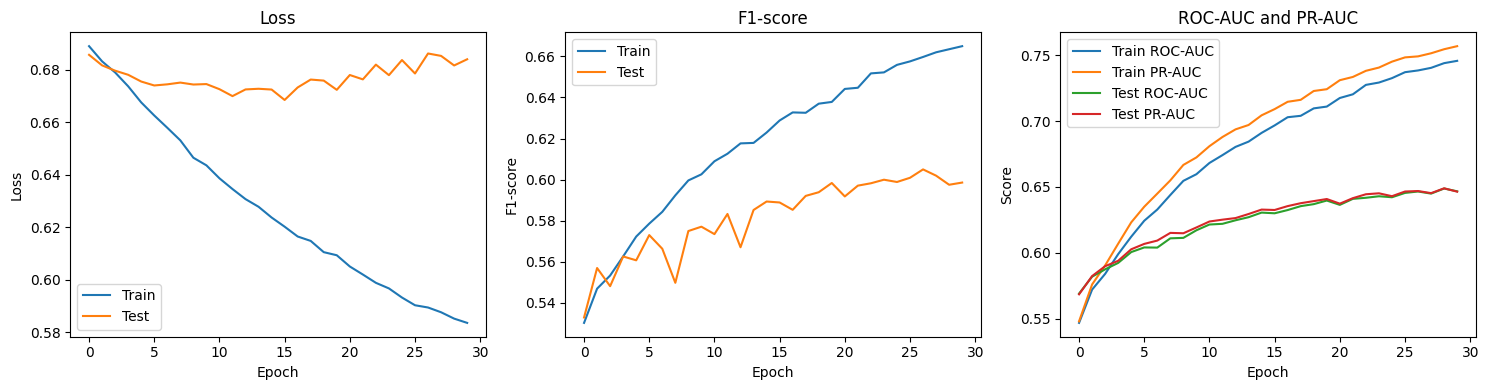

In [57]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score, roc_auc_score, auc
from sklearn.metrics import precision_recall_curve
from torch.utils.data import DataLoader, TensorDataset

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.5, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X.shape[1]
hidden_size = 256
num_layers = 3
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.001

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 16
X_train = torch.tensor(X_train, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).view(-1, 1, X.shape[1]).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)


train_data = torch.utils.data.TensorDataset(X_train, y_train)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_values = []
train_f1_values = []
train_roc_auc_values = []
train_pr_auc_values = []
test_loss_values = []
test_f1_values = []
test_roc_auc_values = []
test_pr_auc_values = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    true_labels = []
    predicted_labels = []
    predicted_probs = []

    for i, (inputs, labels) in enumerate(tqdm(data_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        probs = nn.functional.softmax(outputs, dim=1)
        predicted_probs.extend(probs.cpu().detach().numpy()[:, 1])
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

    epoch_loss /= len(data_loader)
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    roc_auc = roc_auc_score(true_labels, predicted_probs)
    pr, re, _ = precision_recall_curve(true_labels, predicted_probs)
    pr_auc = auc(re, pr)
    
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        probs = nn.functional.softmax(test_outputs, dim=1)
        test_predicted_probs = probs.cpu().detach().numpy()[:, 1]
        _, test_preds = torch.max(test_outputs, 1)
        test_true_labels = y_test.cpu().numpy()
        test_f1 = f1_score(test_true_labels, test_preds.cpu().numpy(), average='weighted')
        test_roc_auc = roc_auc_score(test_true_labels, test_predicted_probs)
        test_pr, test_re, _ = precision_recall_curve(test_true_labels, test_predicted_probs)
        test_pr_auc = auc(test_re, test_pr)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train F1-score: {f1:.4f}, Train ROC-AUC: {roc_auc:.4f}, Train PR-AUC: {pr_auc:.4f}, Test Loss: {test_loss:.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc:.4f}, Test PR-AUC: {test_pr_auc:.4f}')

    train_loss_values.append(epoch_loss)
    train_f1_values.append(f1)
    train_roc_auc_values.append(roc_auc)
    train_pr_auc_values.append(pr_auc)
    test_loss_values.append(test_loss.item())
    test_f1_values.append(test_f1)
    test_roc_auc_values.append(test_roc_auc)
    test_pr_auc_values.append(test_pr_auc)

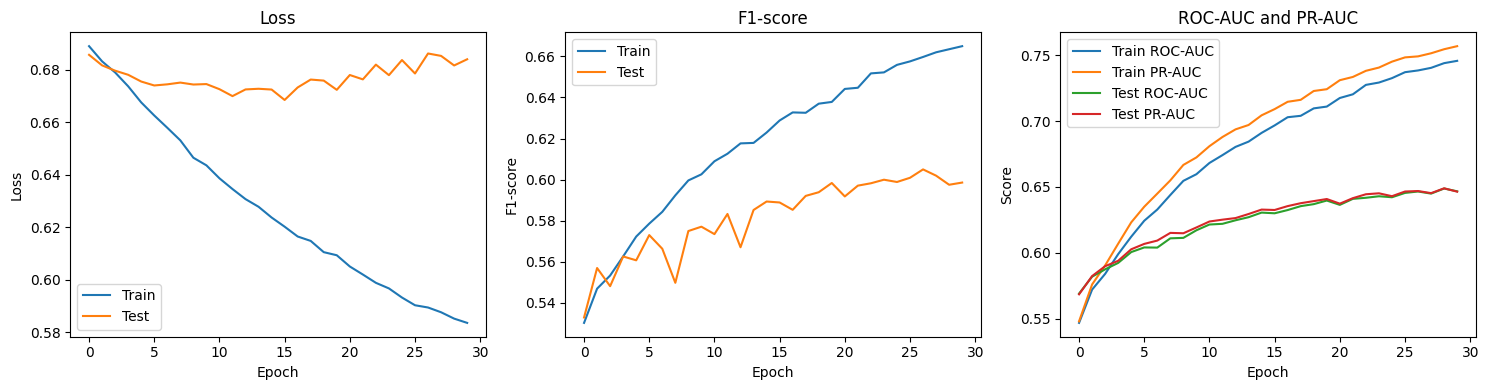

In [58]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_values, label="Train")
ax1.plot(test_loss_values, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_values, label="Train")
ax2.plot(test_f1_values, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_values, label="Train ROC-AUC")
ax3.plot(train_pr_auc_values, label="Train PR-AUC")
ax3.plot(test_roc_auc_values, label="Test ROC-AUC")
ax3.plot(test_pr_auc_values, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import matplotlib.pyplot as plt

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


input_size = X.shape[1]
hidden_size = 128
output_size = 2

model = MLP(input_size, hidden_size, output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train)
X_test = torch.from_numpy(X_test)

epochs = 50
train_loss_history = []
train_f1_history = []
train_roc_auc_history = []
train_pr_auc_history = []
test_loss_history = []
test_f1_history = []
test_roc_auc_history = []
test_pr_auc_history = []


for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        train_outputs = model(X_train)
        _, train_predicted = torch.max(train_outputs, 1)
        train_f1 = f1_score(y_train, train_predicted, average='weighted')
        train_loss_history.append(loss.item())
        train_f1_history.append(train_f1)
        train_roc_auc_history.append(roc_auc_score(y_train, train_outputs[:, 1]))
        train_precision, train_recall, _ = precision_recall_curve(y_train, train_outputs[:, 1])
        train_pr_auc_history.append(auc(train_recall, train_precision))
    with torch.no_grad():
        model.eval()
        test_outputs = model(X_test)
        _, test_predicted = torch.max(test_outputs, 1)
        test_loss = criterion(test_outputs, y_test)
        test_f1 = f1_score(y_test, test_predicted, average='weighted')
        test_loss_history.append(test_loss.item())
        test_f1_history.append(test_f1)
        test_roc_auc = roc_auc_score(y_test, test_outputs[:, 1])
        test_roc_auc_history.append(test_roc_auc)

        test_precision, test_recall, _ = precision_recall_curve(y_test, test_outputs[:, 1])
        test_pr_auc = auc(test_recall, test_precision)
        test_pr_auc_history.append(test_pr_auc)
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Train F1-score: {train_f1:.4f}, Train ROC-AUC: {train_roc_auc_history[-1]:.4f}, Train PR-AUC: {train_pr_auc_history[-1]:.4f}, Test Loss: {test_loss.item():.4f}, Test F1-score: {test_f1:.4f}, Test ROC-AUC: {test_roc_auc_history[-1]:.4f}, Test PR-AUC: {test_pr_auc_history[-1]:.4f}')

Epoch [1/50], Train Loss: 0.6991, Train F1-score: 0.4928, Train ROC-AUC: 0.5062, Train PR-AUC: 0.5076, Test Loss: 0.6981, Test F1-score: 0.4866, Test ROC-AUC: 0.5047, Test PR-AUC: 0.5053
Epoch [2/50], Train Loss: 0.6970, Train F1-score: 0.5137, Train ROC-AUC: 0.5233, Train PR-AUC: 0.5243, Test Loss: 0.6972, Test F1-score: 0.5093, Test ROC-AUC: 0.5197, Test PR-AUC: 0.5199
Epoch [3/50], Train Loss: 0.6959, Train F1-score: 0.5209, Train ROC-AUC: 0.5293, Train PR-AUC: 0.5288, Test Loss: 0.6938, Test F1-score: 0.5158, Test ROC-AUC: 0.5257, Test PR-AUC: 0.5235
Epoch [4/50], Train Loss: 0.6923, Train F1-score: 0.5174, Train ROC-AUC: 0.5298, Train PR-AUC: 0.5287, Test Loss: 0.6940, Test F1-score: 0.5118, Test ROC-AUC: 0.5253, Test PR-AUC: 0.5220
Epoch [5/50], Train Loss: 0.6921, Train F1-score: 0.5304, Train ROC-AUC: 0.5340, Train PR-AUC: 0.5327, Test Loss: 0.6917, Test F1-score: 0.5258, Test ROC-AUC: 0.5289, Test PR-AUC: 0.5245
Epoch [6/50], Train Loss: 0.6898, Train F1-score: 0.5199, Train R

Epoch [45/50], Train Loss: 0.6708, Train F1-score: 0.5742, Train ROC-AUC: 0.6021, Train PR-AUC: 0.6060, Test Loss: 0.6807, Test F1-score: 0.5615, Test ROC-AUC: 0.5816, Test PR-AUC: 0.5764
Epoch [46/50], Train Loss: 0.6703, Train F1-score: 0.5753, Train ROC-AUC: 0.6035, Train PR-AUC: 0.6075, Test Loss: 0.6806, Test F1-score: 0.5618, Test ROC-AUC: 0.5822, Test PR-AUC: 0.5771
Epoch [47/50], Train Loss: 0.6699, Train F1-score: 0.5762, Train ROC-AUC: 0.6049, Train PR-AUC: 0.6090, Test Loss: 0.6804, Test F1-score: 0.5620, Test ROC-AUC: 0.5829, Test PR-AUC: 0.5778
Epoch [48/50], Train Loss: 0.6694, Train F1-score: 0.5767, Train ROC-AUC: 0.6062, Train PR-AUC: 0.6105, Test Loss: 0.6802, Test F1-score: 0.5617, Test ROC-AUC: 0.5835, Test PR-AUC: 0.5786
Epoch [49/50], Train Loss: 0.6689, Train F1-score: 0.5778, Train ROC-AUC: 0.6074, Train PR-AUC: 0.6119, Test Loss: 0.6800, Test F1-score: 0.5622, Test ROC-AUC: 0.5841, Test PR-AUC: 0.5793
Epoch [50/50], Train Loss: 0.6684, Train F1-score: 0.5788, T

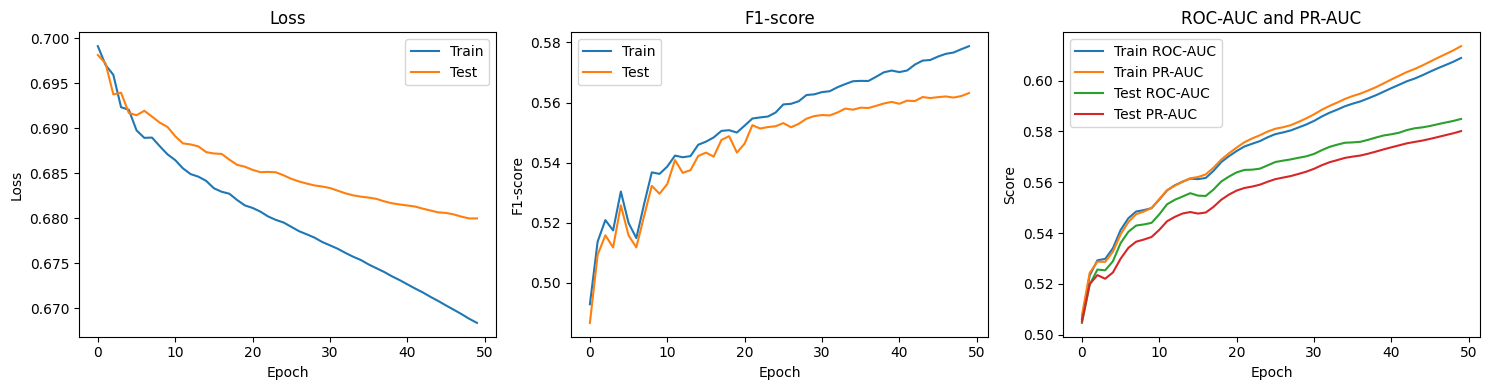

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

ax1.set_title("Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.plot(train_loss_history, label="Train")
ax1.plot(test_loss_history, label="Test")
ax1.legend()

ax2.set_title("F1-score")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("F1-score")
ax2.plot(train_f1_history, label="Train")
ax2.plot(test_f1_history, label="Test")
ax2.legend()

ax3.set_title("ROC-AUC and PR-AUC")
ax3.set_xlabel("Epoch")
ax3.set_ylabel("Score")
ax3.plot(train_roc_auc_history, label="Train ROC-AUC")
ax3.plot(train_pr_auc_history, label="Train PR-AUC")
ax3.plot(test_roc_auc_history, label="Test ROC-AUC")
ax3.plot(test_pr_auc_history, label="Test PR-AUC")
ax3.legend()

fig.tight_layout()
plt.show()

In [61]:
import pandas as pd
import torch
array = X
df_x = pd.DataFrame(array, columns=feature_names)

In [62]:
df_x

,Histone_H3K36me3,Histone_H4K20me3,Histone_H2A,Histone_H3K36me2,Histone_H3K4ac,Histone_H4K20me1,Histone_H3K23ac,Histone_H3K4ox,Histone_H3K27ac,Histone_H2A.X,...,TFs_ZNF444,TFs_ZNF507,TFs_ZNF512B,TFs_ZNF516,TFs_ZNF574,TFs_ZNF579,TFs_ZNF592,TFs_ZNF687,TFs_ZNF711,TFs_ZNF8
0,4.906155,-0.122217,-0.045373,-0.082742,-0.339024,2.032398,-0.219037,-0.070423,0.019200,-0.026974,...,0.118386,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
1,0.875661,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,-0.480783,0.253115,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,0.040127,-0.172508,-0.041989
2,0.909674,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,0.971245,0.303314,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
3,-0.688561,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,-0.480783,-0.822957,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
4,1.311050,-0.122217,-0.045373,-0.082742,0.249215,-0.022156,-0.130140,0.321982,0.696144,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129093,1.795708,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,-0.480783,-0.696056,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
129094,-0.648948,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,-0.110128,-0.224810,-0.026974,...,-0.039555,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
129095,-0.438552,-0.122217,-0.045373,-0.082742,-0.400265,-0.115584,-0.342062,-0.257301,-0.773513,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989
129096,0.627073,0.252702,-0.045373,-0.082742,-0.400265,-0.115584,0.035610,0.612355,0.765231,-0.026974,...,-0.249649,-0.088444,-0.091884,-0.012679,-0.114813,-0.191079,-0.100394,-0.213420,-0.172508,-0.041989


In [63]:
array = y.numpy()
df_y = pd.DataFrame(array, columns=['target'])

In [64]:
df_y

,target
0,0
1,1
2,1
3,1
4,1
...,...
129093,0
129094,1
129095,1
129096,0


In [65]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier()
rf.fit(df_x, df_y)
importances = rf.feature_importances_

for feature, importance in zip(df_x.columns, importances):
    print(f'{feature}: {importance}')

/tmp/ipykernel_26437/162895947.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(df_x, df_y)


Histone_H3K36me3: 0.013077504563945923
Histone_H4K20me3: 0.001196740901879392
Histone_H2A: 6.707109398819399e-05
Histone_H3K36me2: 0.00034109292755363826
Histone_H3K4ac: 0.00239125997752428
Histone_H4K20me1: 0.00045305299802284575
Histone_H3K23ac: 0.0017665544559000005
Histone_H3K4ox: 0.0077290894954252535
Histone_H3K27ac: 0.02366239279253955
Histone_H2A.X: 3.746509306044666e-05
Histone_H3K9me3: 0.016050384230829093
Histone_H3K9me2: 0.003501133586404435
Histone_H2A.Z: 0.0057572769327041496
Histone_H1.X: 6.23421376106952e-06
Histone_H3K18ac: 0.0011439493575311362
Histone_H3: 0.003445103261672641
Histone_H1.4S187ph: 1.692853092878086e-05
Histone_H2BK120ub1: 0.0013514482804197173
Histone_H3T45ph: 2.1326333812555104e-05
Histone_H3K79me2: 0.006093422201877735
Histone_H4K8ac: 0.005423236203581015
Histone_H4K12ac: 0.009158476762562979
Histone_H3K9K14ac: 0.0028331816087332124
Histone_H2Bub: 0.00040359613689620053
Histone_H2A.XS139ph: 0.002006051908637132
Histone_H4ac: 4.6365942302669343e-07
Hi

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, precision_recall_curve, auc


X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision, recall, _ = precision_recall_curve(y_test, y_pred)
pr_auc = auc(recall, precision)

print(f'F1-score: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')


/tmp/ipykernel_26437/4292731798.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


F1-score: 0.6668
ROC-AUC: 0.6684
PR-AUC: 0.7496


              feature    importance
8     Histone_H3K27ac  2.199890e-02
32   Histone_H3K27me3  2.091163e-02
37    Histone_H3K4me1  1.896309e-02
299          TFs_SFPQ  1.837901e-02
152         TFs_FOXA1  1.635151e-02
..                ...           ...
218         TFs_MEPCE  4.777864e-07
350          TFs_TOP1  4.957817e-08
79           TFs_BPTF  0.000000e+00
281         TFs_RBBP5  0.000000e+00
90          TFs_CASP3  0.000000e+00

[405 rows x 2 columns]


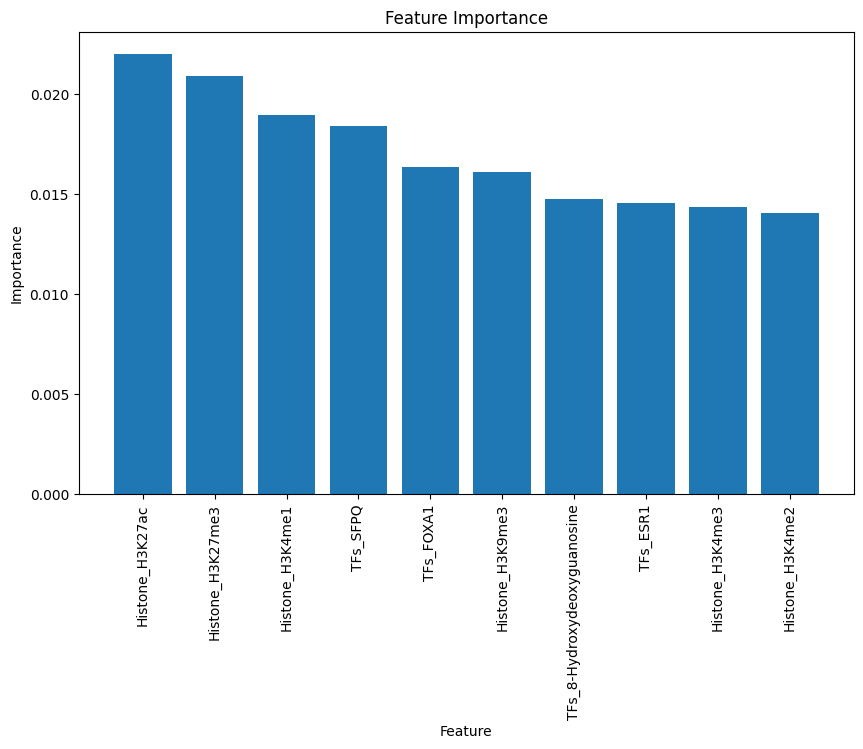

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

importances = rf.feature_importances_

df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})

df_importances = df_importances.sort_values('importance', ascending=False)

print(df_importances)

plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [68]:
import catboost as cb
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=42)
model = cb.CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1,
    depth=6, 
    random_seed=42,
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
pr_roc = average_precision_score(y_test, y_pred)

print(f"F1: {f1}, AUC-ROC: {auc_roc}, PR-ROC: {pr_roc}")

0:	learn: 0.6922266	total: 80.6ms	remaining: 1m 20s
1:	learn: 0.6914856	total: 111ms	remaining: 55.2s
2:	learn: 0.6906897	total: 144ms	remaining: 47.7s
3:	learn: 0.6900576	total: 178ms	remaining: 44.2s
4:	learn: 0.6894368	total: 207ms	remaining: 41.2s
5:	learn: 0.6887573	total: 238ms	remaining: 39.5s
6:	learn: 0.6882576	total: 268ms	remaining: 38s
7:	learn: 0.6878604	total: 301ms	remaining: 37.3s
8:	learn: 0.6874901	total: 333ms	remaining: 36.6s
9:	learn: 0.6870232	total: 364ms	remaining: 36s
10:	learn: 0.6866704	total: 392ms	remaining: 35.3s
11:	learn: 0.6863798	total: 423ms	remaining: 34.9s
12:	learn: 0.6861659	total: 452ms	remaining: 34.3s
13:	learn: 0.6858580	total: 484ms	remaining: 34.1s
14:	learn: 0.6856497	total: 514ms	remaining: 33.7s
15:	learn: 0.6853323	total: 545ms	remaining: 33.5s
16:	learn: 0.6849910	total: 575ms	remaining: 33.2s
17:	learn: 0.6847357	total: 607ms	remaining: 33.1s
18:	learn: 0.6845842	total: 636ms	remaining: 32.8s
19:	learn: 0.6843546	total: 666ms	remaining

163:	learn: 0.6620243	total: 4.92s	remaining: 25.1s
164:	learn: 0.6618598	total: 4.95s	remaining: 25s
165:	learn: 0.6616779	total: 4.98s	remaining: 25s
166:	learn: 0.6615387	total: 5s	remaining: 25s
167:	learn: 0.6613594	total: 5.03s	remaining: 24.9s
168:	learn: 0.6611892	total: 5.06s	remaining: 24.9s
169:	learn: 0.6609932	total: 5.09s	remaining: 24.9s
170:	learn: 0.6608267	total: 5.12s	remaining: 24.8s
171:	learn: 0.6606536	total: 5.15s	remaining: 24.8s
172:	learn: 0.6604886	total: 5.18s	remaining: 24.8s
173:	learn: 0.6603370	total: 5.21s	remaining: 24.7s
174:	learn: 0.6602146	total: 5.24s	remaining: 24.7s
175:	learn: 0.6600760	total: 5.26s	remaining: 24.6s
176:	learn: 0.6599685	total: 5.29s	remaining: 24.6s
177:	learn: 0.6598178	total: 5.32s	remaining: 24.6s
178:	learn: 0.6596522	total: 5.34s	remaining: 24.5s
179:	learn: 0.6594534	total: 5.37s	remaining: 24.5s
180:	learn: 0.6593138	total: 5.4s	remaining: 24.4s
181:	learn: 0.6591578	total: 5.43s	remaining: 24.4s
182:	learn: 0.6590115	

327:	learn: 0.6381392	total: 9.7s	remaining: 19.9s
328:	learn: 0.6380379	total: 9.73s	remaining: 19.8s
329:	learn: 0.6379065	total: 9.76s	remaining: 19.8s
330:	learn: 0.6377464	total: 9.79s	remaining: 19.8s
331:	learn: 0.6376561	total: 9.82s	remaining: 19.8s
332:	learn: 0.6375037	total: 9.85s	remaining: 19.7s
333:	learn: 0.6373699	total: 9.88s	remaining: 19.7s
334:	learn: 0.6372633	total: 9.9s	remaining: 19.7s
335:	learn: 0.6371510	total: 9.93s	remaining: 19.6s
336:	learn: 0.6370518	total: 9.96s	remaining: 19.6s
337:	learn: 0.6369265	total: 9.99s	remaining: 19.6s
338:	learn: 0.6367661	total: 10s	remaining: 19.5s
339:	learn: 0.6366153	total: 10s	remaining: 19.5s
340:	learn: 0.6365188	total: 10.1s	remaining: 19.5s
341:	learn: 0.6363982	total: 10.1s	remaining: 19.4s
342:	learn: 0.6362745	total: 10.1s	remaining: 19.4s
343:	learn: 0.6361516	total: 10.2s	remaining: 19.4s
344:	learn: 0.6360538	total: 10.2s	remaining: 19.3s
345:	learn: 0.6359455	total: 10.2s	remaining: 19.3s
346:	learn: 0.6358

490:	learn: 0.6185093	total: 14.4s	remaining: 15s
491:	learn: 0.6183915	total: 14.5s	remaining: 14.9s
492:	learn: 0.6182898	total: 14.5s	remaining: 14.9s
493:	learn: 0.6181449	total: 14.5s	remaining: 14.9s
494:	learn: 0.6179831	total: 14.6s	remaining: 14.9s
495:	learn: 0.6179353	total: 14.6s	remaining: 14.8s
496:	learn: 0.6178028	total: 14.6s	remaining: 14.8s
497:	learn: 0.6177210	total: 14.7s	remaining: 14.8s
498:	learn: 0.6176124	total: 14.7s	remaining: 14.7s
499:	learn: 0.6175183	total: 14.7s	remaining: 14.7s
500:	learn: 0.6173633	total: 14.7s	remaining: 14.7s
501:	learn: 0.6172610	total: 14.8s	remaining: 14.7s
502:	learn: 0.6171202	total: 14.8s	remaining: 14.6s
503:	learn: 0.6169489	total: 14.8s	remaining: 14.6s
504:	learn: 0.6167872	total: 14.9s	remaining: 14.6s
505:	learn: 0.6166959	total: 14.9s	remaining: 14.5s
506:	learn: 0.6165880	total: 14.9s	remaining: 14.5s
507:	learn: 0.6164380	total: 15s	remaining: 14.5s
508:	learn: 0.6163233	total: 15s	remaining: 14.5s
509:	learn: 0.6162

652:	learn: 0.6011617	total: 19.2s	remaining: 10.2s
653:	learn: 0.6010826	total: 19.2s	remaining: 10.2s
654:	learn: 0.6009442	total: 19.3s	remaining: 10.2s
655:	learn: 0.6008524	total: 19.3s	remaining: 10.1s
656:	learn: 0.6007809	total: 19.3s	remaining: 10.1s
657:	learn: 0.6006786	total: 19.4s	remaining: 10.1s
658:	learn: 0.6005877	total: 19.4s	remaining: 10s
659:	learn: 0.6004535	total: 19.4s	remaining: 10s
660:	learn: 0.6003301	total: 19.5s	remaining: 9.98s
661:	learn: 0.6002388	total: 19.5s	remaining: 9.95s
662:	learn: 0.6001055	total: 19.5s	remaining: 9.92s
663:	learn: 0.6000428	total: 19.5s	remaining: 9.89s
664:	learn: 0.5999587	total: 19.6s	remaining: 9.86s
665:	learn: 0.5998537	total: 19.6s	remaining: 9.83s
666:	learn: 0.5997564	total: 19.6s	remaining: 9.8s
667:	learn: 0.5996915	total: 19.7s	remaining: 9.77s
668:	learn: 0.5996288	total: 19.7s	remaining: 9.74s
669:	learn: 0.5994908	total: 19.7s	remaining: 9.71s
670:	learn: 0.5993948	total: 19.8s	remaining: 9.68s
671:	learn: 0.599

813:	learn: 0.5855694	total: 24s	remaining: 5.49s
814:	learn: 0.5854635	total: 24s	remaining: 5.46s
815:	learn: 0.5854161	total: 24.1s	remaining: 5.42s
816:	learn: 0.5853136	total: 24.1s	remaining: 5.4s
817:	learn: 0.5852423	total: 24.1s	remaining: 5.37s
818:	learn: 0.5851431	total: 24.2s	remaining: 5.34s
819:	learn: 0.5850456	total: 24.2s	remaining: 5.31s
820:	learn: 0.5849448	total: 24.2s	remaining: 5.28s
821:	learn: 0.5849028	total: 24.2s	remaining: 5.25s
822:	learn: 0.5848334	total: 24.3s	remaining: 5.22s
823:	learn: 0.5847566	total: 24.3s	remaining: 5.19s
824:	learn: 0.5846618	total: 24.3s	remaining: 5.16s
825:	learn: 0.5845943	total: 24.4s	remaining: 5.13s
826:	learn: 0.5845041	total: 24.4s	remaining: 5.1s
827:	learn: 0.5843826	total: 24.4s	remaining: 5.07s
828:	learn: 0.5842646	total: 24.5s	remaining: 5.04s
829:	learn: 0.5841698	total: 24.5s	remaining: 5.01s
830:	learn: 0.5841126	total: 24.5s	remaining: 4.98s
831:	learn: 0.5840424	total: 24.5s	remaining: 4.96s
832:	learn: 0.5839

974:	learn: 0.5713886	total: 28.8s	remaining: 739ms
975:	learn: 0.5713041	total: 28.9s	remaining: 710ms
976:	learn: 0.5711862	total: 28.9s	remaining: 680ms
977:	learn: 0.5710724	total: 28.9s	remaining: 651ms
978:	learn: 0.5709946	total: 28.9s	remaining: 621ms
979:	learn: 0.5708986	total: 29s	remaining: 591ms
980:	learn: 0.5708018	total: 29s	remaining: 562ms
981:	learn: 0.5706721	total: 29s	remaining: 532ms
982:	learn: 0.5705758	total: 29.1s	remaining: 503ms
983:	learn: 0.5704799	total: 29.1s	remaining: 473ms
984:	learn: 0.5703738	total: 29.1s	remaining: 444ms
985:	learn: 0.5702519	total: 29.2s	remaining: 414ms
986:	learn: 0.5702008	total: 29.2s	remaining: 384ms
987:	learn: 0.5701291	total: 29.2s	remaining: 355ms
988:	learn: 0.5700675	total: 29.2s	remaining: 325ms
989:	learn: 0.5699621	total: 29.3s	remaining: 296ms
990:	learn: 0.5698733	total: 29.3s	remaining: 266ms
991:	learn: 0.5697910	total: 29.3s	remaining: 237ms
992:	learn: 0.5697323	total: 29.4s	remaining: 207ms
993:	learn: 0.5696

In [69]:
feature_importances = model.feature_importances_
for feature_name, feature_importance in zip(df_x.columns, feature_importances):
    print(f"{feature_name}: {feature_importance}")

Histone_H3K36me3: 1.2656570598990216
Histone_H4K20me3: 0.15612461432133798
Histone_H2A: 0.0
Histone_H3K36me2: 0.1579858921109578
Histone_H3K4ac: 0.20442550973162407
Histone_H4K20me1: 0.03630384681518667
Histone_H3K23ac: 0.5753165781458722
Histone_H3K4ox: 0.9182784447519385
Histone_H3K27ac: 1.0323252957203313
Histone_H2A.X: 0.0121058494581795
Histone_H3K9me3: 1.4099531896915605
Histone_H3K9me2: 0.4865032932462361
Histone_H2A.Z: 0.6307936939500804
Histone_H1.X: 2.922264026635663e-05
Histone_H3K18ac: 0.16805993856374554
Histone_H3: 0.36618104149735686
Histone_H1.4S187ph: 0.0
Histone_H2BK120ub1: 0.20120406556611192
Histone_H3T45ph: 0.0
Histone_H3K79me2: 0.4948762676867997
Histone_H4K8ac: 0.30761899673991605
Histone_H4K12ac: 0.7238815615396219
Histone_H3K9K14ac: 0.16542764676701233
Histone_H2Bub: 0.044340312110672825
Histone_H2A.XS139ph: 0.2216956614571595
Histone_H4ac: 0.0
Histone_H2BP1me1: 0.011436372435877045
Histone_H3K27me2: 0.0
Histone_H3K9ac: 0.29577852834421353
Histone_H3K4me2: 1.03

              feature  importance
299          TFs_SFPQ    2.857274
357        TFs_TRIM25    1.873761
32   Histone_H3K27me3    1.807076
10    Histone_H3K9me3    1.409953
37    Histone_H3K4me1    1.310930
..                ...         ...
108         TFs_COPS2    0.000000
360        TFs_TRMT13    0.000000
95           TFs_CBX8    0.000000
93           TFs_CBX6    0.000000
147        TFs_FBXO44    0.000000

[405 rows x 2 columns]


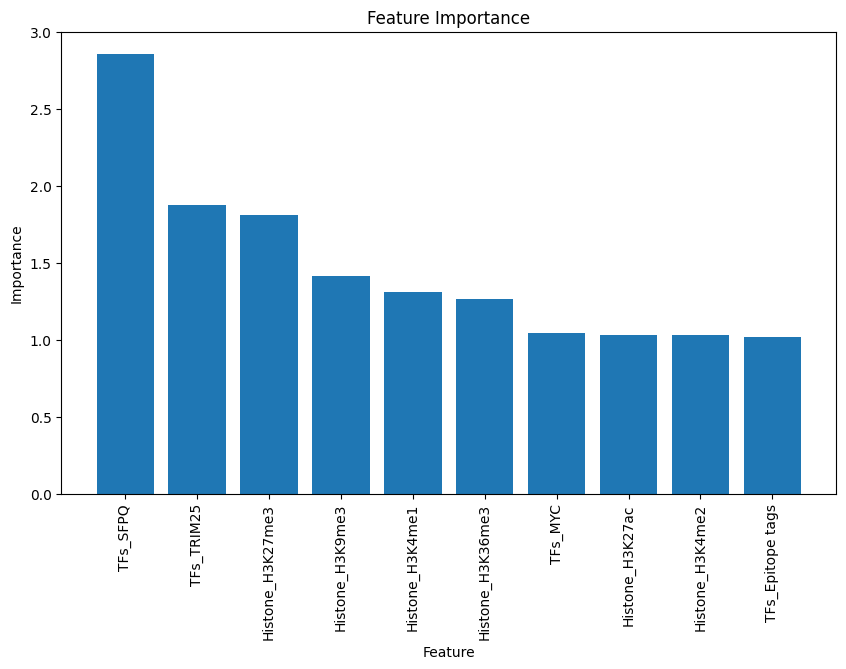

In [70]:
importances = feature_importances
df_importances = pd.DataFrame({'feature': df_x.columns, 'importance': importances})
df_importances = df_importances.sort_values('importance', ascending=False)
print(df_importances)

plt.figure(figsize=(10, 6))
plt.bar(df_importances['feature'][:10], df_importances['importance'][:10])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()
